<a href="https://colab.research.google.com/github/ritwiks9635/CNN_Project_File/blob/main/Gradient_Class_Activation_Map.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**GradCAM - Gradient Class Activation Map**

In [ ]:
!git clone https://github.com/parth1620/GradCAM-Dataset.git
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

In [2]:
import sys
sys.path.append('/content/GradCAM-Dataset')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

import torch
from torch import nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms as T

from tqdm import tqdm
import albumentations as A
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import utils

In [4]:
CSV_FILE = '/content/GradCAM-Dataset/train.csv'
DATA_DIR = '/content/GradCAM-Dataset/'

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

BATCH_SIZE = 16
LR = 0.001
EPOCHS = 20

In [5]:
DEVICE

'cuda'

In [6]:
data = pd.read_csv(CSV_FILE)
data.head()

,img_path,label
0,train_images/mushroom_51.jpg,2
1,train_images/eggplant_37.jpg,1
2,train_images/mushroom_20.jpg,2
3,train_images/eggplant_51.jpg,1
4,train_images/eggplant_26.jpg,1


In [7]:
train_df, valid_df = train_test_split(data, test_size = 0.2, random_state = 42)

#**Augmentations**

In [8]:
train_augs = A.Compose([
      A.Rotate(),
      A.HorizontalFlip(0.5),
      A.VerticalFlip(0.5),
      A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


valid_augs = A.Compose([
      A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#**Load Image Dataset**

In [9]:
trainset = utils.ImageDataset(df = train_df, augs = train_augs, data_dir = DATA_DIR)
validset = utils.ImageDataset(df = valid_df, augs = valid_augs, data_dir = DATA_DIR)

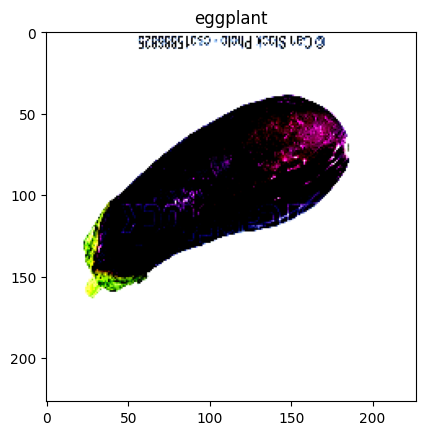

In [10]:
image, label = trainset[145]

class_list = ['cucumber', 'eggplant', 'mushroom']

# image in Torch.Tensor, shape=(c, h, w)
plt.imshow(image.permute(1, 2, 0))
plt.title(class_list[label]);

In [11]:
print("No of example Train Dataset ::", len(trainset))
print("No of example Valid Dataset ::", len(validset))

No of example Train Dataset :: 148
No of example Valid Dataset :: 38


#**Load Dataset into Batches**

In [12]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE, shuffle = False)

In [13]:
print("No. of batch in Train set :: ", len(trainloader))
print("No. of batch in Valid set :: ", len(validloader))

No. of batch in Train set ::  10
No. of batch in Valid set ::  3


In [14]:
for image, label in trainloader:
    print("One batch imags shape :: ", image.shape)
    print("One batch label shape :: ", label.shape)
    break

One batch imags shape ::  torch.Size([16, 3, 227, 227])
One batch label shape ::  torch.Size([16])


#**Create Model**

In [15]:
class ImageModel(nn.Module):
  def __init__(self) -> None:
    super(ImageModel, self).__init__()

    self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(5, 5), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(4, 4), stride=2),

            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(5, 5), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(4, 4), stride=2),

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(5, 5), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(4, 4), stride=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5, 5), padding=1),
            nn.ReLU()
    )
    self.maxpool = nn.MaxPool2d(kernel_size=(4, 4), stride=2)
    self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(6400, 2048),
            nn.ReLU(),
            nn.Linear(2048, 3)
    )
    self.gradient = None

  def activations_hook(self, grad):
    self.gradient = grad

  def forward(self, images):
    x = self.feature_extractor(images)  # use as activation maps -> multiply weights(*a1) w/ activation maps

    h = x.register_hook(self.activations_hook)

    x = self.maxpool(x)
    x = self.classifier(x)
    return x

  def get_activation_gradients(self): # return gradient a1, a2, ..., ak
    return self.gradient

  def get_activation(self, x):  # return activation A1, A2, ..., Ak
    return self.feature_extractor(x)  # shape=(64, 8, 8) as (c, h, w)

In [16]:
model = ImageModel()
model.to(DEVICE)

ImageModel(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=6400, out_features=2048, bias=True)
    (2): ReLU()
    (3): Linear(in_features=2048, out_features=3, bias=True)
  )
)

#**Create Train and Eval function**

In [17]:
def train_fn(dataloader: DataLoader, model: ImageModel, optimizer, criterion):
  model.train()
  total_loss = 0.0
  for images, labels in tqdm(dataloader):
    images, labels = images.to(DEVICE), labels.to(DEVICE)

    optimizer.zero_grad()
    logits = model(images)  # no activation
    loss = criterion(logits, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
  return total_loss/len(dataloader)

In [26]:
def eval_fn(dataloader: DataLoader, model: ImageModel, criterion):
  model.eval()
  total_loss = 0.0
  for images, labels in tqdm(dataloader):
    images, labels = images.to(DEVICE), labels.to(DEVICE)


    logits = model(images)  # no activation
    loss = criterion(logits, labels)


    total_loss += loss.item()
  return total_loss/len(dataloader)

#**Training Loop**

In [27]:
optimizer = torch.optim.Adam(params = model.parameters(), lr = LR)
criterion = torch.nn.CrossEntropyLoss()

In [28]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer, criterion)
  valid_loss = eval_fn(validloader, model, criterion)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_weights.pt')
    best_valid_loss = valid_loss
    print('SAVE_WEIGHT_SUCCESS')

  print(f'EPOCH: {i+1} \t TRAIN_LOSS: {train_loss} \t VALID_LOSS: {valid_loss}')

100%|██████████| 3/3 [00:00<00:00, 30.51it/s]


SAVE_WEIGHT_SUCCESS
EPOCH: 1 	 TRAIN_LOSS: 1.1007882833480835 	 VALID_LOSS: 0.9986526171366373


100%|██████████| 3/3 [00:00<00:00, 33.40it/s]


SAVE_WEIGHT_SUCCESS
EPOCH: 2 	 TRAIN_LOSS: 0.6664809912443161 	 VALID_LOSS: 0.8865918815135956


100%|██████████| 3/3 [00:00<00:00, 30.70it/s]


SAVE_WEIGHT_SUCCESS
EPOCH: 3 	 TRAIN_LOSS: 0.5971039727330207 	 VALID_LOSS: 0.6420127252737681


100%|██████████| 3/3 [00:00<00:00, 23.80it/s]


SAVE_WEIGHT_SUCCESS
EPOCH: 4 	 TRAIN_LOSS: 0.35677489042282107 	 VALID_LOSS: 0.4199935992558797


100%|██████████| 3/3 [00:00<00:00, 23.79it/s]


SAVE_WEIGHT_SUCCESS
EPOCH: 5 	 TRAIN_LOSS: 0.25606740862131117 	 VALID_LOSS: 0.13377340883016586


100%|██████████| 3/3 [00:00<00:00, 22.24it/s]


EPOCH: 6 	 TRAIN_LOSS: 0.10361154656857252 	 VALID_LOSS: 0.1491388128294299


100%|██████████| 3/3 [00:00<00:00, 31.50it/s]


EPOCH: 7 	 TRAIN_LOSS: 0.04269492444582283 	 VALID_LOSS: 0.15732975775608793


100%|██████████| 3/3 [00:00<00:00, 32.84it/s]


EPOCH: 8 	 TRAIN_LOSS: 0.07649100522976368 	 VALID_LOSS: 0.5025851361763974


100%|██████████| 3/3 [00:00<00:00, 29.09it/s]


EPOCH: 9 	 TRAIN_LOSS: 0.09440550506260478 	 VALID_LOSS: 0.15238765378793082


100%|██████████| 3/3 [00:00<00:00, 33.57it/s]


SAVE_WEIGHT_SUCCESS
EPOCH: 10 	 TRAIN_LOSS: 0.034660066734068094 	 VALID_LOSS: 0.11015927574286859


100%|██████████| 3/3 [00:00<00:00, 30.74it/s]


EPOCH: 11 	 TRAIN_LOSS: 0.05004077721387148 	 VALID_LOSS: 0.17011814564466476


100%|██████████| 3/3 [00:00<00:00, 33.27it/s]


EPOCH: 12 	 TRAIN_LOSS: 0.1124913256673608 	 VALID_LOSS: 0.12913504630948106


100%|██████████| 3/3 [00:00<00:00, 32.47it/s]


EPOCH: 13 	 TRAIN_LOSS: 0.06952136092222645 	 VALID_LOSS: 0.1477496325969696


100%|██████████| 3/3 [00:00<00:00, 34.64it/s]


EPOCH: 14 	 TRAIN_LOSS: 0.09033992846962065 	 VALID_LOSS: 0.16637179589209458


100%|██████████| 3/3 [00:00<00:00, 28.85it/s]


EPOCH: 15 	 TRAIN_LOSS: 0.10832728275563568 	 VALID_LOSS: 0.1871776517946273


100%|██████████| 3/3 [00:00<00:00, 31.39it/s]


EPOCH: 16 	 TRAIN_LOSS: 0.04349657143466175 	 VALID_LOSS: 0.21943860997756323


100%|██████████| 3/3 [00:00<00:00, 31.43it/s]


EPOCH: 17 	 TRAIN_LOSS: 0.013366959215682072 	 VALID_LOSS: 0.14463130213941136


100%|██████████| 3/3 [00:00<00:00, 35.02it/s]


EPOCH: 18 	 TRAIN_LOSS: 0.012324710068060084 	 VALID_LOSS: 0.12668407250506183


100%|██████████| 3/3 [00:00<00:00, 30.38it/s]


EPOCH: 19 	 TRAIN_LOSS: 0.003762943536275998 	 VALID_LOSS: 0.13677166332490742


100%|██████████| 3/3 [00:00<00:00, 33.23it/s]

EPOCH: 20 	 TRAIN_LOSS: 0.009255925589604886 	 VALID_LOSS: 0.12327423575334251


#**Get GradCAM**

In [29]:
def get_grad_cam(model, image, label, size):
  label.backward()
  gradients = model.get_activation_gradients()
  pooled_gradients = torch.mean(gradients, dim=(0, 2, 3)) # get gradient weights: a1, a2, ..., ak
  activations = model.get_activation(image).detach()  # get activation map: A1, A2, ..., Ak

  for i in range(activations.shape[1]): # number of channel
    activations[:, i, :, :] *= pooled_gradients[i]

  heatmap = torch.mean(activations, dim=1).squeeze().cpu()
  heatmap = nn.ReLU()(heatmap)
  heatmap /= torch.max(heatmap)
  heatmap = cv2.resize(heatmap.numpy(), (size, size))

  return heatmap

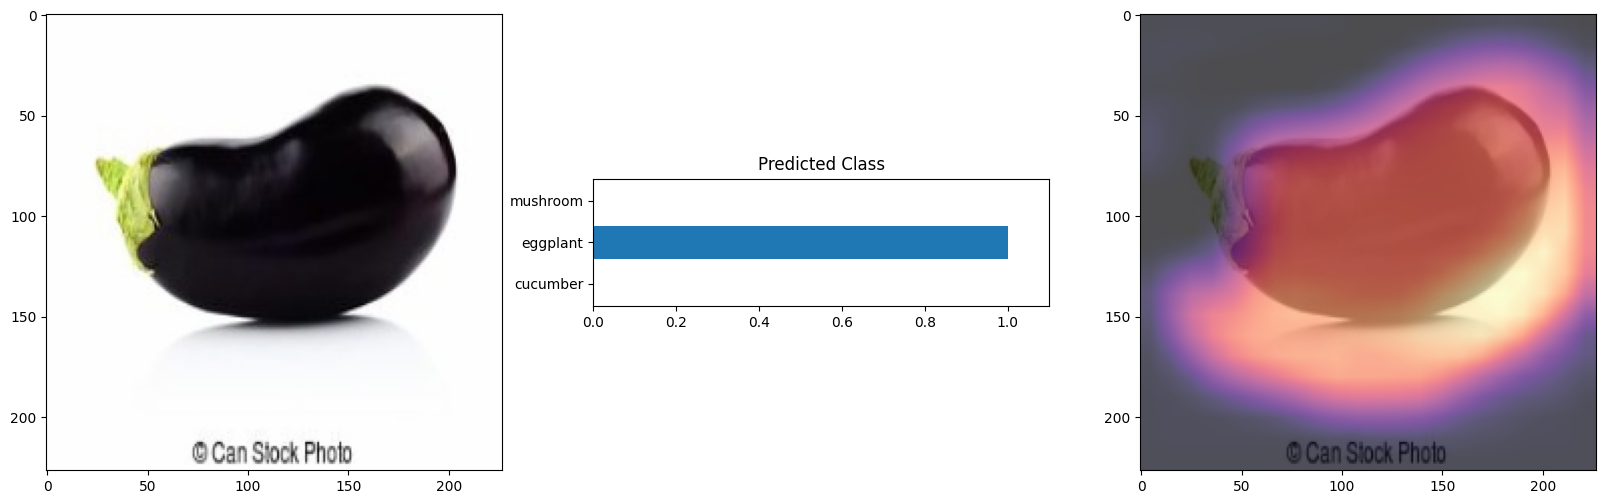

In [34]:
image, label = validset[15]

denorm_img = image.permute(1, 2, 0) * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))

image = image.unsqueeze(0).to(DEVICE)

pred = model(image)
# Label: cucumber - 0, eggplant - 1, mushroom - 2
# pred[0] returns label list, pred[0][1] is eggplant
heatmap = get_grad_cam(model, image, pred[0][1], size=227)
utils.plot_heatmap(denorm_img, pred, heatmap)